In [13]:
import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the data: the FordA dataset

## Dataset description
The dataset we are using here is called FordA. The data comes from the UCR archive. The dataset contains 3601 training instances and another 1320 testing instances. Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. For this task, the goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task. The full description of this dataset can be found here.

## Read the TSV data
We will use the FordA_TRAIN file for training and the FordA_TEST file for testing. The simplicity of this dataset allows us to demonstrate effectively how to use ConvNets for timeseries classification. In this file, the first column corresponds to the label.

In [14]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# Visualize the data

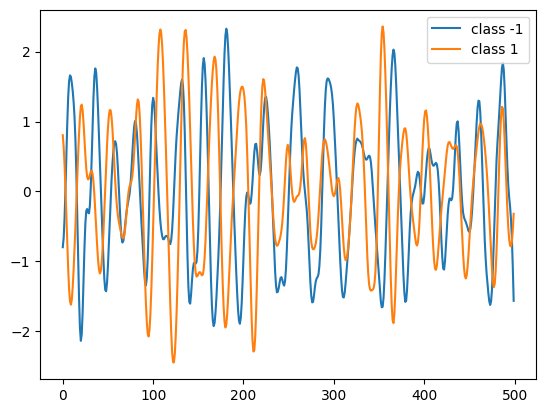

In [15]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

# Standardize the data

Our timeseries are already in a single length (500). However, their values are usually in various ranges. This is not ideal for a neural network; in general we should seek to make the input values normalized. For this specific dataset, the data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see Bagnall et al. (2016).

Note that the timeseries data used here are univariate, meaning we only have one channel per timeseries example. We will therefore transform the timeseries into a multivariate one with one channel using a simple reshaping via numpy. This will allow us to construct a model that is easily applicable to multivariate time series.

In [16]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [17]:
x_train.shape

(3601, 500, 1)

Finally, in order to use sparse_categorical_crossentropy, we will have to count the number of classes beforehand.

In [18]:
num_classes = len(np.unique(y_train))


Now we shuffle the training set because we will be using the validation_split option later when training.

In [19]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers. The expected labels will then be 0 and 1.

In [20]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [21]:
def make_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=input_shape),
        keras.layers.BatchNormalization(),

        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
        keras.layers.BatchNormalization(),

        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
        keras.layers.BatchNormalization(),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(num_classes, activation="softmax")
    ])

    return model


model = make_model(input_shape=x_train.shape[1:], num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


/Users/alainsanchezgonzalez/venvKerasExamples/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Build and train the model

We build a Fully Convolutional Neural Network originally proposed in this paper. The implementation is based on the TF 2 version provided here. The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found via random search using KerasTuner.

In [22]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.5934 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.7734 - val_sparse_categorical_accuracy: 0.4730 - learning_rate: 0.0010
Epoch 2/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.4424 - sparse_categorical_accuracy: 0.7947 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.4730 - learning_rate: 0.0010
Epoch 3/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.4262 - sparse_categorical_accuracy: 0.7838 - val_loss: 1.3505 - val_sparse_categorical_accuracy: 0.4730 - learning_rate: 0.0010
Epoch 4/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.4204 - sparse_categorical_accuracy: 0.7999 - val_loss: 1.9401 - val_sparse_categorical_accuracy: 0.4730 - learning_rate: 0.0010
Epoch 5/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.4075 - sparse_categorical_accuracy: 0.7982 - val_loss: 1.5820 - val_sparse_categorical_accuracy: 0.4730 - learning_rate: 0.0010
Epoch 6/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms

# Evaluate model on test data


In [23]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9251
Test accuracy 0.9090909361839294
Test loss 0.21285377442836761


# Plot the model's training and validation loss

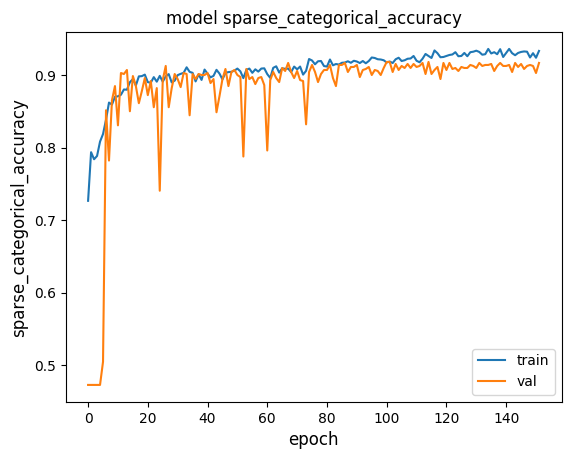

In [24]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs. However, by observing the validation accuracy we can see how the network still needs training until it reaches almost 0.97 for both the validation and the training accuracy after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation accuracy will start decreasing while the training accuracy will continue on increasing: the model starts overfitting.